# Integration in gene space using transmorph

In this notebook, we use MNNCorrection to integrate datasets in gene space.

## Loading data

In [1]:
from transmorph.datasets import load_chen_10x

# Format: {patient_label -> AnnData}
datasets = load_chen_10x()

databank_api > Loading bank chen_10x.
databank_api > Bank chen_10x successfully loaded.


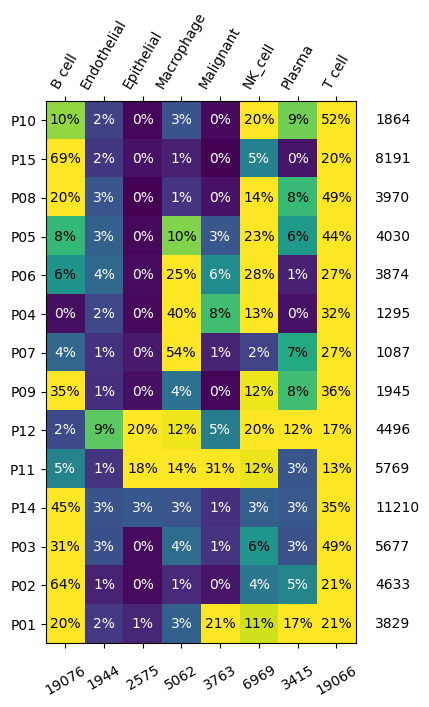

In [2]:
# Displaying cell type distribution across batches

from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(datasets, label="class")

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def get_color(i, palette_size):
    cmap = cm.get_cmap('rainbow')
    return cmap(i/(palette_size-1))

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

def scatter_plot(figure, datasets, obsm_rep, obs_class, mode="class", legend_on_plot=False, legendtitle=None):
    if not isinstance(datasets, dict):
        datasets = {"": datasets}
        
    X_tot = np.zeros((0,2))
    y_dataset = np.zeros((0,))
    y_class = np.zeros((0,))
    for name, dataset in datasets.items():
        X_tot = np.concatenate((X_tot, dataset.obsm[obsm_rep]), axis=0)
        y_dataset = np.concatenate((y_dataset, [name]*dataset.n_obs), axis=0)
        y_class = np.concatenate((y_class, dataset.obs[obs_class]), axis=0)
        
    if mode == "class":
        y = y_class
    else:
        assert mode == "dataset", f"unrecognized mode: {mode}"
        y = y_dataset
        
    ax = figure.add_subplot(111)
    for i, label in enumerate(sorted(set(y))):
        if label == 'n/a':
            continue
        selector = y == label
        X = X_tot[selector]
        ax.scatter(*X.T, label=label, s=1, color=get_color(i, len(set(y))))
        if legend_on_plot:
            bbox_opt = {
                "facecolor": "white", 
                "edgecolor": "white", 
                "alpha": 0.5, 
                "pad": 0
            }
            plt.text(
                *X.mean(axis=0), 
                label, 
                size="small",
                ha="center", 
                va="center", 
                bbox=bbox_opt
            )
        
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a legend
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    maxletters = max([len(str(ylab)) for ylab in set(y)]) # calibrated for figsize(4.5,4)
    ax.legend(
        loc="center right", 
        bbox_to_anchor=(1.80, 0.5), 
        markerscale=5,
        fontsize=14,
        ncol=2
    )

In [4]:
from transmorph.utils.plotting import reduce_dimension

reduce_dimension(datasets, output_obsm='base_umap')

DEBUG:transmorph._logging:umap > Duplicates detected. Jittering data.
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((1864, 2)) in obsm[base_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_base_umap]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((8191, 2)) in obsm[base_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_base_umap]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((3970, 2)) in obsm[base_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_base_umap]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((4030, 2)) in obsm[base_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_base_umap]
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((3874, 2)) in obsm[base_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_base_umap]
DEBUG:transmorph._lo

Text(0, 0.5, 'UMAP2')

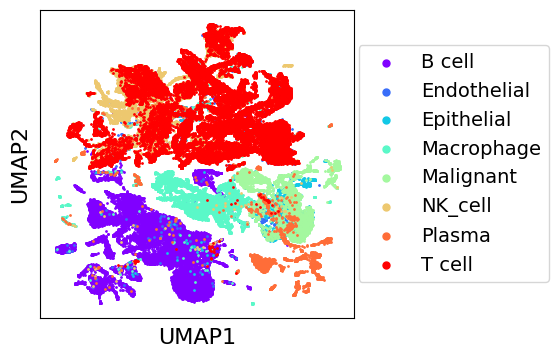

In [44]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "base_umap", "class", legendtitle="Cell type")
plt.xlabel("UMAP1", fontsize=16)
plt.ylabel("UMAP2", fontsize=16)

Text(0, 0.5, 'UMAP2')

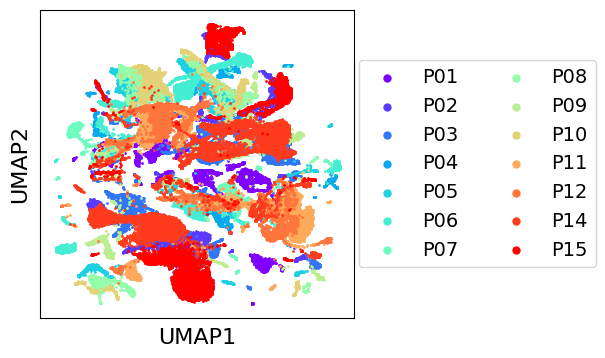

In [42]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, datasets, "base_umap", "class", mode="dataset", legendtitle="Dataset")
plt.xlabel("UMAP1", fontsize=16)
plt.ylabel("UMAP2", fontsize=16)

## MNNCorrection

In [ ]:
from transmorph.models import MNNCorrection

bknn_model = MNNCorrection(matching="bknn")
bknn_model.transform(datasets, reference=datasets["P12"])

In [10]:
import anndata as ad
import numpy as np

X_tot = np.zeros((0,924))
obs_batch = np.zeros((0,))
obs_class = np.zeros((0,))
obs_names = np.zeros((0,))
for name, adata in datasets.items():
    X_tot = np.concatenate((X_tot, adata.obsm['transmorph']))
    obs_batch = np.concatenate((obs_batch, [name]*adata.n_obs))
    obs_class = np.concatenate((obs_class, adata.obs['class']))
    obs_names = np.concatenate((obs_names, adata.obs_names))
    
adata_tot = ad.AnnData(X_tot, dtype=np.float32)
adata_tot.obs_names = obs_names
adata_tot.var_names = bknn_model.embedding_features
adata_tot.obs["class"] = obs_class
adata_tot.obs['batch'] = obs_batch

In [11]:
adata_tot.write_h5ad('data/counts_correction_bknn_v2.h5ad')

## Analysis

In [46]:
import anndata as ad

adata_bknn = ad.read_h5ad('data/counts_correction_bknn_v2.h5ad')

In [47]:
from transmorph.utils.plotting import reduce_dimension

reduce_dimension(adata_bknn, output_obsm='bknn_umap')

DEBUG:transmorph._logging:umap > Duplicates detected. Jittering data.
DEBUG:transmorph._logging:ADManager > Inserting <class 'numpy.ndarray'> ((61870, 2)) in obsm[bknn_umap]
DEBUG:transmorph._logging:ADManager > Inserting umap in uns[reducer_bknn_umap]


Text(0, 0.5, 'BKNNCorrection + UMAP2')

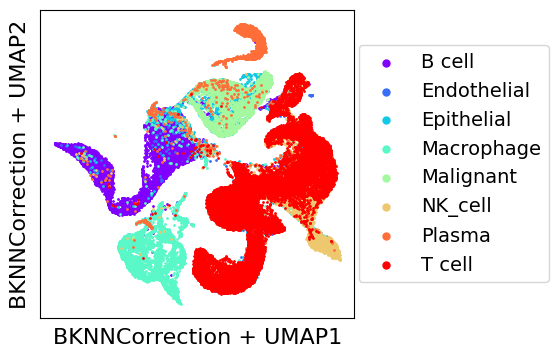

In [48]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, adata_bknn, "bknn_umap", "class", legendtitle="Cell type")
plt.xlabel("BKNNCorrection + UMAP1", fontsize=16)
plt.ylabel("BKNNCorrection + UMAP2", fontsize=16)

Text(0, 0.5, 'BKNNCorrection + UMAP2')

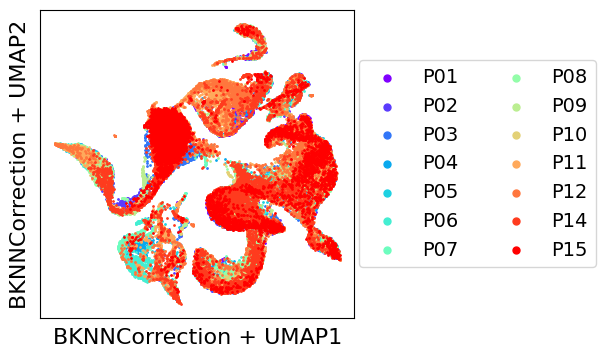

In [50]:
fig = plt.figure(figsize=(4.5,4))
scatter_plot(fig, adata_bknn, "bknn_umap", "batch", legendtitle="Dataset")
plt.xlabel("BKNNCorrection + UMAP1", fontsize=16)
plt.ylabel("BKNNCorrection + UMAP2", fontsize=16)

In [51]:
from transmorph.stats import lisi

lisib = {}
lisib['base'] = lisi(datasets, perplexity=30)
lisib['bknn'] = lisi(datasets, obsm="transmorph", perplexity=30)

DEBUG:transmorph._logging:nearest_neighbors > Duplicates detected. Jittering.
DEBUG:transmorph._logging:nearest_neighbors > Computing nearest neighbors using nndescent.
DEBUG:transmorph._logging:nearest_neighbors > n: 61870, kmin: 90, kmax: 90
DEBUG:transmorph._logging:nearest_neighbors > Duplicates detected. Jittering.
DEBUG:transmorph._logging:nearest_neighbors > Computing nearest neighbors using nndescent.
DEBUG:transmorph._logging:nearest_neighbors > n: 61870, kmin: 90, kmax: 90


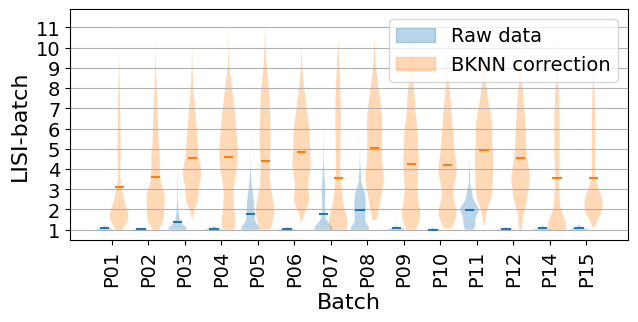

In [72]:
batch_order = np.argsort(list(datasets.keys()))
lisib['base'] = [lisib['base'][i] for i in batch_order]
lisib['bknn'] = [lisib['bknn'][i] for i in batch_order]

plt.figure(figsize=(8,3))
vp_b_base = plt.violinplot(lisib['base'], positions=np.arange(14)-.2, widths=.5, showmeans=True, showextrema=False)
vp_b_bknn = plt.violinplot(lisib['bknn'], positions=np.arange(14)+.2, widths=.5, showmeans=True, showextrema=False)

labels = []
add_label(vp_b_base, "Raw data")
add_label(vp_b_bknn, "BKNN correction")

plt.xticks(np.arange(14), sorted(datasets.keys()), fontsize=14, rotation=90)
plt.yticks(1+np.arange(11), fontsize=14)
plt.ylabel('LISI-batch', fontsize=16)
plt.xlabel('Batch', fontsize=16)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    fontsize=14
)

plt.grid(axis="y")
pass

In [73]:
lisic = {}
lisic['base'] = lisi(datasets, obs="class", perplexity=30)
lisic['bknn'] = lisi(datasets, obs="class", obsm="transmorph", perplexity=30)

DEBUG:transmorph._logging:nearest_neighbors > Duplicates detected. Jittering.
DEBUG:transmorph._logging:nearest_neighbors > Computing nearest neighbors using nndescent.
DEBUG:transmorph._logging:nearest_neighbors > n: 61870, kmin: 90, kmax: 90
DEBUG:transmorph._logging:nearest_neighbors > Duplicates detected. Jittering.
DEBUG:transmorph._logging:nearest_neighbors > Computing nearest neighbors using nndescent.
DEBUG:transmorph._logging:nearest_neighbors > n: 61870, kmin: 90, kmax: 90


In [74]:
all_classes = set(np.concatenate([adata.obs['class'] for adata in datasets.values()], axis=0))
lisi_c_perclass = {}
for rep in lisic:
    lisi_rep = []
    for ctype in all_classes:
        lisi_ctype = np.zeros((0,))
        for adata, lisi_adata in zip(datasets.values(), lisic[rep]):
            lisi_ctype = np.concatenate((lisi_ctype, lisi_adata[adata.obs['class'] == ctype]))
        lisi_rep.append(lisi_ctype)
    lisi_c_perclass[rep] = lisi_rep

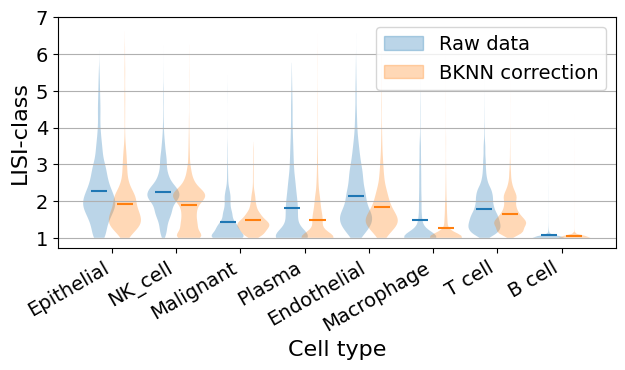

In [81]:
plt.figure(figsize=(8,3))
vp_b_base = plt.violinplot(lisi_c_perclass['base'], positions=np.arange(8)-.2, widths=.5, showmeans=True, showextrema=False)
vp_b_bknn = plt.violinplot(lisi_c_perclass['bknn'], positions=np.arange(8)+.2, widths=.5, showmeans=True, showextrema=False)

labels = []
add_label(vp_b_base, "Raw data")
add_label(vp_b_bknn, "BKNN correction")

plt.xticks(np.arange(8), all_classes, fontsize=14, rotation=30, ha="right")
plt.yticks(1+np.arange(7), fontsize=14)
plt.ylabel('LISI-class', fontsize=16)
plt.xlabel('Cell type', fontsize=16)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    fontsize=14
)
plt.grid(axis='y')
pass

## ICA

In [83]:
N_ICS = 30
cell_type_ica = 'T cell'

In [84]:
# Before correction
import sica

X_tot = np.zeros((0, len(bknn_model.embedding_features)))
cell_selector = np.zeros((0,), dtype=int)
for adata in datasets.values():
    cell_selector_k = adata.obs['class'] == cell_type_ica
    X_tot = np.concatenate((X_tot, adata[cell_selector_k, bknn_model.embedding_features].X), axis=0)
    cell_selector = np.concatenate((cell_selector, cell_selector_k), axis=0)

ica_model_raw = sica.base.StabilizedICA(n_components=N_ICS, max_iter=2000)
ica_model_raw.fit(X_tot.T, n_runs=20)
raw_ica_genevsic = ica_model_raw.S_.T.copy() # try X.T @ S^-1
raw_ica_icvscell = ica_model_raw.A_.T.copy()

In [85]:
from numpy import corrcoef

def get_ic_batch_signal(ic_coefs, batches):
    coefs = []
    for batch in set(batches):
        y_batch = batches.to_numpy() == batch
        coefs.append(corrcoef(ic_coefs, y_batch)[1, 0])
    return coefs

coeficbatch = np.zeros((len(set(adata_bknn.obs['batch'])), N_ICS))
for ic in range(N_ICS):
    coeficbatch[:, ic] = get_ic_batch_signal(raw_ica_icvscell.T[:, ic], adata_bknn.obs['batch'][cell_selector.astype(bool)])

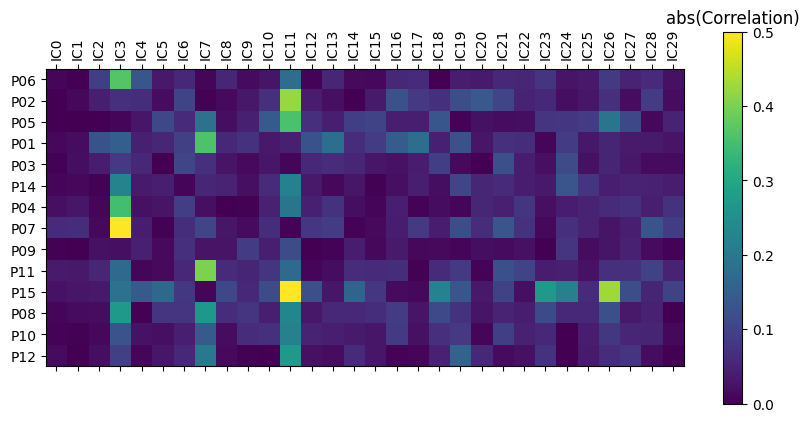

In [86]:
plt.matshow(np.abs(coeficbatch), vmin=0, vmax=.5)
cbar = plt.colorbar()
cbar.ax.set_title("abs(Correlation)")
plt.xticks(np.arange(N_ICS), [f'IC{i}' for i in range(N_ICS)], rotation=90)
plt.yticks(np.arange(14), set(adata_bknn.obs['batch']))
pass

In [87]:
# Before correction
import sica

cell_selector = adata_bknn.obs['class'] == cell_type_ica
X_tot = adata_bknn.X[cell_selector]

ica_model_bknn = sica.base.StabilizedICA(n_components=N_ICS, max_iter=2000)
ica_model_bknn.fit(X_tot.T, n_runs=20)
bknn_ica_genevsic = ica_model_bknn.S_.T.copy() # try X.T @ S^-1
bknn_ica_icvscell = ica_model_bknn.A_.T.copy()

In [88]:
from numpy import corrcoef

def get_ic_batch_signal(ic_coefs, batches):
    coefs = []
    for batch in set(batches):
        y_batch = batches.to_numpy() == batch
        coefs.append(corrcoef(ic_coefs, y_batch)[1, 0])
    return coefs

coeficbatch2 = np.zeros((len(set(adata_bknn.obs['batch'])), N_ICS))
for ic in range(N_ICS):
    coeficbatch2[:, ic] = get_ic_batch_signal(bknn_ica_icvscell.T[:, ic], adata_bknn.obs['batch'][cell_selector])

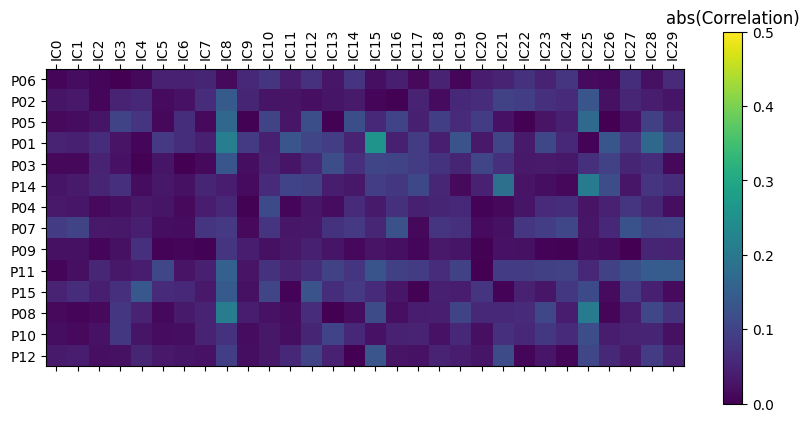

In [89]:
plt.matshow(np.abs(coeficbatch2), vmin=0, vmax=.5)
cbar = plt.colorbar()
cbar.ax.set_title("abs(Correlation)")
plt.xticks(np.arange(N_ICS), [f'IC{i}' for i in range(N_ICS)], rotation=90)
plt.yticks(np.arange(14), set(adata_bknn.obs['batch']))
pass

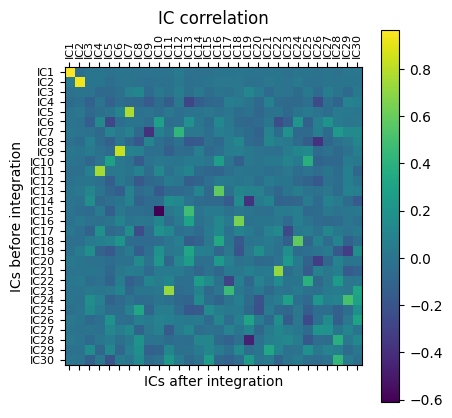

In [90]:
corricic = np.corrcoef(raw_ica_genevsic.T, bknn_ica_genevsic.T)

plt.matshow(corricic[:N_ICS, N_ICS:])
plt.xlabel("ICs after integration")
plt.ylabel("ICs before integration")
plt.title("IC correlation")
plt.xticks(np.arange(N_ICS), [f'IC{i}' for i in range(1, N_ICS+1)], rotation=90, fontsize=8)
plt.yticks(np.arange(N_ICS), [f'IC{i}' for i in range(1, N_ICS+1)], fontsize=8)
plt.colorbar()